# Assignment #4: A simple language classifier with scikit-learn and PyTorch

Author: Pierre Nugues

## Objectives

In this assignment, you will implement a language detector inspired and simplified from Google's _Compact language detector_, version 3 (CLD3): https://github.com/google/cld3. CLD3 is written in C++ and its code is available from GitHub. CLD3 can scale to many languages and complemented with other techniques as you can read here: https://arxiv.org/pdf/2205.03983

The objectives of the assignment are to:
* Write a program to classify languages
* Use neural networks with sklearn and PyTorch
* Understand how to evaluate a classifier
* Write a short individual report of 2 to 3 pages to describe your program.

The outline of the lab is:
1. You will first collect and preprocess a dataset;
2. You will create a language classifier using sklearn, an easy-to-use API. This should enable you to understand the concepts with a top-down approach as you will have less details to manage;
3. You will reimplement the classifier using PyTorch, a deep-learning API, where you will write the gradient descent loop explicitly;
4. In both experiments, you will evaluate your classification results. 

## Description

### System Overview

Read the GitHub description of CLD3, https://github.com/google/cld3, (_Model_ section). In your individual report, you will summarize it in two or three sentences in the _Method and program structure_ section. 

## Imports

In [336]:
import bz2
import json
import os
import numpy as np
import requests
import sys
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import hashlib
from tqdm import tqdm
import regex as re

In [337]:
random.seed(1234)
np.random.seed(1234)
torch.manual_seed(1234)

## Dataset

As dataset, we will use Tatoeba, https://tatoeba.org/eng/downloads. It consists of more than 12 million short texts in more than 400 languages and it is available in one file called `sentences.csv`.

The dataset is structured this way: There is one text per line, where each line consists of the three following fields separated by tabulations and ended by a carriage return:
```
sentence id [tab] language code [tab] text [cr]
```
Each text (sentence) has a unique id and has a language code that follows the ISO 639-3 standard (see below). 

### Scope of the lab

In this lab, you will consider six languages only: French (fra), Japanese (jpn), Chinese (cmn), English (eng), Swedish (swe), and Danish (dan). Below is an excerpt of the Tatoeba dataset limited to three languages: 

```
1276    eng     Let's try something.
1277    eng     I have to go to sleep.
1280    eng     Today is June 18th and it is Muiriel's birthday!
...
1115    fra     Lorsqu'il a demandé qui avait cassé la fenêtre, tous les garçons ont pris un air innocent.
1279    fra     Je ne supporte pas ce type.
1441    fra     Pour une fois dans ma vie je fais un bon geste... Et ça ne sert à rien.
...
337413  swe     Vi trodde att det var ett flygande tefat.
341910  swe     Detta är huset jag bodde i när jag var barn.
341938  swe     Vi hade roligt på stranden igår.
...
```
Tatoeba is updated continuously. The examples from this dataset come from a corpus your instructor downloaded on September 17, 2024.

## Getting the Dataset

Before you start programming the rest, download the Tatoeba dataset. You can use the instructions (uncomment them):

In [338]:
#!wget https://downloads.tatoeba.org/exports/sentences.tar.bz2

In [339]:
#!tar -xvjf sentences.tar.bz2

### Loading the Dataset

Run the code to read the dataset and split it into lines. You may have to change the path

In [340]:
dataset_large = open('sentences.csv', encoding='utf8').read().strip()
dataset_large = dataset_large.split('\n')
dataset_large[:10]

['1\tcmn\t我們試試看！',
 '2\tcmn\t我该去睡觉了。',
 '3\tcmn\t你在干什麼啊？',
 '4\tcmn\t這是什麼啊？',
 '5\tcmn\t今天是６月１８号，也是Muiriel的生日！',
 '6\tcmn\t生日快乐，Muiriel！',
 '7\tcmn\tMuiriel现在20岁了。',
 '8\tcmn\t密码是"Muiriel"。',
 '9\tcmn\t我很快就會回來。',
 '10\tcmn\t我不知道。']

The size may vary as new documents are added every day to _Tatoeba_

In [341]:
len(dataset_large)

12290349

Run the code to split the fields and remove possible whitespaces

In [342]:
dataset_large = list(map(lambda x: tuple(x.split('\t')), dataset_large))
dataset_large = list(map(lambda x: tuple(map(str.strip, x)), dataset_large))
dataset_large[:3]

[('1', 'cmn', '我們試試看！'), ('2', 'cmn', '我该去睡觉了。'), ('3', 'cmn', '你在干什麼啊？')]

In [343]:
from collections import Counter
counter = Counter(map(lambda x: x[1], dataset_large))

Again the figures may vary

In [344]:
counter.most_common(30)

[('eng', 1921698),
 ('rus', 1086725),
 ('ita', 889215),
 ('epo', 767991),
 ('tur', 734644),
 ('kab', 723927),
 ('deu', 696576),
 ('ber', 678266),
 ('fra', 632505),
 ('por', 433956),
 ('hun', 411857),
 ('spa', 408460),
 ('jpn', 241941),
 ('heb', 201541),
 ('ukr', 186340),
 ('nld', 186188),
 ('fin', 149857),
 ('pol', 128872),
 ('lit', 113131),
 ('ces', 80171),
 ('mkd', 78226),
 ('tgl', 76301),
 ('cmn', 74582),
 ('mar', 73276),
 ('ara', 64655),
 ('dan', 63434),
 ('tok', 58853),
 ('swe', 56165),
 ('lat', 51380),
 ('srp', 50655)]

In [345]:
len(counter)

420

## Understanding the ${X}$ matrix (feature matrix)
You will now investigate the CLD3 features. In your report, you will describe the features CLD3 extracts from each text.

Write a program to create a simplified ${X}$ matrix where you will represent the 9 texts with CLD3 features. You will use a restricted set of features: You will only consider the letters _a_, _b_, and _n_ and the bigrams _an_, _ba_, and _na_. You will ignore the the rest of letters and bigrams as well as the trigrams. Your matrix will have 9 rows and 6 columns, each column will contain these counts: `[#a, #b, #n, #an, #ba, #na]`.

The CLD3's original description uses relative frequencies (counts of a letter divided by the total counts of letters in the text). Here, you will use the raw counts.

To help you start your program to extract the counts, you can use the `str.count()` function

In [346]:
example_ngrams = ['a', 'b', 'n', 'an', 'ba', 'na']

In [347]:
"""Lorsqu'il a demandé qui avait cassé la fenêtre, tous les garçons ont pris un air innocent.""".count(
    'a')

8

In [348]:
"""Lorsqu'il a demandé qui avait cassé la fenêtre, tous les garçons ont pris un air innocent.""".count(
    'an')

1

In [349]:
my_string = """Lorsqu'il a demandé qui avait cassé la fenêtre, tous les garçons ont pris un air innocent."""
row = []
for ngram in example_ngrams:
    row += [my_string.count(ngram)]
row

[8, 0, 8, 1, 0, 0]

The indices of the test sentences

In [350]:
test_idx = list(
    map(str, [1276, 1277, 1280, 1115, 1279, 1441, 337413, 341910, 341938]))
test_idx

['1276', '1277', '1280', '1115', '1279', '1441', '337413', '341910', '341938']

Write the code to extract the feature matrix from the test sentences as well as the languages. 
You will store the features in an $X$ matrix and the languages in an $\mathbf{y}$ vector.
You will __include this matrix in your report__ in the _Method and program structure section_.

In [351]:
X = []
y = []
for idx, lang, line in dataset_large:
    if str(idx) in test_idx:
        #print(idx, line)
        row = []
        for ngram in example_ngrams:
            row.append(line.count(ngram))
        X.append(row)
        y.append(lang)
X, y

([[8, 0, 8, 1, 0, 0],
  [0, 0, 1, 0, 0, 0],
  [1, 0, 0, 0, 0, 0],
  [1, 0, 1, 0, 0, 0],
  [3, 1, 2, 1, 0, 0],
  [4, 1, 6, 1, 0, 0],
  [4, 0, 1, 1, 0, 0],
  [5, 2, 2, 0, 1, 0],
  [2, 0, 2, 1, 0, 0]],
 ['fra', 'eng', 'eng', 'fra', 'eng', 'fra', 'swe', 'swe', 'swe'])

## Restricting the Dataset to a few Languages 

The Tatoeba dataset is very large. You will first extract a subset of it

Write the code to extract texts in the languages below. For each language, you limit the number of documents to 50,000 or less if the language has less documents.
You will call the resulting dataset: `dataset`

The languages

In [352]:
langs = ['fra', 'cmn', 'jpn', 'eng', 'swe', 'dan']

The maximal number of documents per language

In [353]:
MAX_DOCS = 50000

Write a loop that:
1. Extracts a list of all the documents in a certain language from the dataset
2. Shuffles this list with `random.shuffle()`
3. Adds `MAX_DOCS` to `dataset`. You just need to use a slice

In [354]:
# Write your code here
dataset = []
for lang in langs:
    docs = list(filter(lambda x: x[1] == lang, dataset_large))
    random.shuffle(docs)
    dataset += docs[:MAX_DOCS]

In [355]:
random.shuffle(dataset)

In [356]:
len(dataset)

300000

In [357]:
dataset[:5]

[('5874154', 'swe', 'I mitt hus gäller mina regler.'),
 ('330777', 'jpn', 'そして我々が過去のあったようにもどるとそれは起こらないだろう。'),
 ('6548315',
  'fra',
  "J'ai fait le pied de grue devant le cinéma pendant une demie heure parce que Thomas était en retard."),
 ('11820070', 'eng', 'Fyodor sat with his sister.'),
 ('154715', 'jpn', '私は日本語の先生になりたい。')]

## Utilities

Before you can use the dataset to train a model, you need to convert it into numbers. You will carry this with out the following steps and you will write a corresponding function.
1. You will extract the $n$-grams up to trigrams (`all_ngrams()`);
2. Trigrams can create many symbols that most student's machines cannot process. You will reduce their numbers using hash codes (`hash_ngrams()`);
3. You will compute the relative frequencies of the $n$-grams, replaced here by the hash codes (`calc_ref_freq()`).
4. The results will be stored in three dictionaries, for characters, bigrams, and trigrams. You will merge these dictionaries into one (`shift_keys()`).

You will then apply the functions to vectorize the dataset.

### Extracting $n$-grams
The goal of this section is that you extract the $n$-grams from a text. By default, you will lowercase the text. The result will have the form: `[chars, bigrams, trigrams]`

Write a function to extract the $n$-grams of a sentence: `ngrams(sentence, n=1, lc=True)`, `n` is a parameters. You can use list slices for this.

In [358]:
# Write your code here
def ngrams(sentence, n=1, lc=True):
    ngram_l = []
    for i in range(len(sentence)):
        if lc:
            ngram = sentence[:n].lower()
        else:
            ngram = sentence[:n]
        if len(ngram) == n:
            ngram_l.append(ngram)
        sentence = sentence[1:]
    return ngram_l

# Snygg lösning:
    # if lc:
    #     sentence.lower()
    # return [''.join(j) for j in zip(*[sentence[i:] for i in range(n)])]

In [359]:
ngrams('try something.')

['t', 'r', 'y', ' ', 's', 'o', 'm', 'e', 't', 'h', 'i', 'n', 'g', '.']

In [360]:
ngrams('try something.', n=2)

['tr', 'ry', 'y ', ' s', 'so', 'om', 'me', 'et', 'th', 'hi', 'in', 'ng', 'g.']

We now use this function to extract all the $n$-grams

In [361]:
def all_ngrams(sentence, max_ngram=3, lc=True):
    all_ngram_list = []
    for i in range(1, max_ngram + 1):
        all_ngram_list += [ngrams(sentence, n=i, lc=lc)]
    return all_ngram_list

In [362]:
all_ngrams('try something.')

[['t', 'r', 'y', ' ', 's', 'o', 'm', 'e', 't', 'h', 'i', 'n', 'g', '.'],
 ['tr',
  'ry',
  'y ',
  ' s',
  'so',
  'om',
  'me',
  'et',
  'th',
  'hi',
  'in',
  'ng',
  'g.'],
 ['try',
  'ry ',
  'y s',
  ' so',
  'som',
  'ome',
  'met',
  'eth',
  'thi',
  'hin',
  'ing',
  'ng.']]

### Hashing

We consider languages with many characters that will make the number of bigrams and trigrams impossible to process. We will use the _hashing trick_ to reduce them, where we will gather $n$-grams into subsets using hash codes.

Each item will have this format:
`[char_hcodes, bigram_hcodes, trigram_hcodes]`.

#### Description

Python has a built-in hashing function that returns a unique numerical signature for a given string

In [363]:
hash('a'), hash('ab'), hash('abc')

(9059731952263618366, 8537080263251960344, 947915581759079344)

If we take the remainder (modulo) of a division by 5, we reduce the possible codes to: 0, 1, 2, 3, or 4

In [364]:
list(map(lambda x: x % 5, (hash('a'), hash('ab'), hash('abc'))))

[1, 4, 4]

#### Implementation

We set maximal numbers for our $n$-grams using these divisors

In [365]:
MAX_CHARS = 521
MAX_BIGRAMS = 1031
MAX_TRIGRAMS = 1031

Here strings have integer codes within the range [0, `MAX_CHARS`[

In [366]:
list(map(lambda x: x % MAX_CHARS, (hash('a'), hash('ab'), hash('abc'))))

[237, 221, 337]

Hash codes may vary across machines and Marcus Klang wrote this function to have reproducible codes

In [367]:
def reproducible_hash(string):
    """
    reproducible hash on any string

    Arguments:
       string: python string object

    Returns:
       signed int64
    """

    # We are using MD5 for speed not security.
    h = hashlib.md5(string.encode("utf-8"), usedforsecurity=False)
    return int.from_bytes(h.digest()[0:8], 'big', signed=True)

In [368]:
reproducible_hash('a')

919145239626757800

In [369]:
reproducible_hash('a') % MAX_CHARS

234

In [370]:
list(map(lambda x: x % MAX_CHARS, (reproducible_hash('a'), reproducible_hash('ab'), reproducible_hash('abc'))))

[234, 465, 184]

### Converting $n$-grams to hash codes
You will now convert the $n$-grams to hash codes


In [371]:
MAXES = [MAX_CHARS, MAX_BIGRAMS, MAX_TRIGRAMS]

Create a `hash_ngrams` function that creates a list of hash codes from a list of $n$-grams. As arguments, you will have the list of $n$-grams `[chars, bigrams, trigrams]` as well as the list of dividers (`MAXES`).

The output format will be a list of three lists:

`[char_hcodes, bigram_hcodes, trigram_hcodes]`.

In [372]:
# Write your code
def hash_ngrams(ngrams, modulos):
    hash_codes = []
    for i in range(3):
        hash_seq = [reproducible_hash(seq) % modulos[i] for seq in ngrams[i]]
        # for seq in ngrams[i]:
        #     hash_seq.append(reproducible_hash(seq) % modulos[i])
        hash_codes.append(hash_seq)
    return hash_codes

In [373]:
all_ngrams('try something.')

[['t', 'r', 'y', ' ', 's', 'o', 'm', 'e', 't', 'h', 'i', 'n', 'g', '.'],
 ['tr',
  'ry',
  'y ',
  ' s',
  'so',
  'om',
  'me',
  'et',
  'th',
  'hi',
  'in',
  'ng',
  'g.'],
 ['try',
  'ry ',
  'y s',
  ' so',
  'som',
  'ome',
  'met',
  'eth',
  'thi',
  'hin',
  'ing',
  'ng.']]

In [374]:
hash_ngrams(all_ngrams('try something.'), MAXES)

[[432, 437, 309, 86, 331, 97, 100, 32, 432, 332, 233, 310, 31, 442],
 [6, 765, 224, 203, 557, 176, 590, 711, 527, 757, 919, 57, 685],
 [848, 617, 468, 456, 873, 996, 287, 10, 817, 674, 960, 399]]

### Functions to Count Hash Codes

Write a function `calc_rel_freq(codes)` to count the codes. As in CLD3, you will return the relative frequencies.

This is just an application of `Counter` to a list of codes and then a division by the length.

The input is a list of codes and the output is a `Counter` object of relative frequencies.

In [375]:
# Write your code
def calc_rel_freq(codes):
    cnt = Counter(codes)
    rel_freq = {code: count / len(codes) for code, count in cnt.items()}
    return Counter(rel_freq)

In [376]:
hash_ngrams(all_ngrams('try something.'), MAXES)

[[432, 437, 309, 86, 331, 97, 100, 32, 432, 332, 233, 310, 31, 442],
 [6, 765, 224, 203, 557, 176, 590, 711, 527, 757, 919, 57, 685],
 [848, 617, 468, 456, 873, 996, 287, 10, 817, 674, 960, 399]]

In [377]:
list(map(calc_rel_freq, hash_ngrams(all_ngrams('try something.'), MAXES)))

[Counter({432: 0.14285714285714285,
          437: 0.07142857142857142,
          309: 0.07142857142857142,
          86: 0.07142857142857142,
          331: 0.07142857142857142,
          97: 0.07142857142857142,
          100: 0.07142857142857142,
          32: 0.07142857142857142,
          332: 0.07142857142857142,
          233: 0.07142857142857142,
          310: 0.07142857142857142,
          31: 0.07142857142857142,
          442: 0.07142857142857142}),
 Counter({6: 0.07692307692307693,
          765: 0.07692307692307693,
          224: 0.07692307692307693,
          203: 0.07692307692307693,
          557: 0.07692307692307693,
          176: 0.07692307692307693,
          590: 0.07692307692307693,
          711: 0.07692307692307693,
          527: 0.07692307692307693,
          757: 0.07692307692307693,
          919: 0.07692307692307693,
          57: 0.07692307692307693,
          685: 0.07692307692307693}),
 Counter({848: 0.08333333333333333,
          617: 0.08333333333333

### Merge the Dictionaries

In the results above, we have three counter objects with numerical keys (the hash codes). You will build one dictionary of them.

There is a key overlap and we must take care that a same hash code for the unigrams is not the same as in the bigrams. We will then shift the keys.

The keys range from:
1. Unigrams from 0 to 521, [0, MAX_CHARS[
2. Bigrams from 0 to 1031, [0, MAX_BIGRAMS[
3. Trigrams from 1 to 1031, [0, MAX_TRIGRAMS[

You will leave the unigrams keys as they are. You will shift the bigram keys by MAX_CHARS, and the trigram keys by MAX_CHARS + MAX_BIGRAMS. You can reuse the code below

In [378]:
MAX_SHIFT = []
for i in range(len(MAXES)):
    MAX_SHIFT += [sum(MAXES[:i])]

In [379]:
MAX_SHIFT

[0, 521, 1552]

Write a `shift_keys(dicts, MAX_SHIFT)` function that takes a list of dictionaries as input and the list of shifts and that a new unique dictionary, where the numerical keys have been shifted by the numbers in `MAX_SHIFT`

In [380]:
# Write your code here
# Given kod
def shift_keys(dicts, MAX_SHIFT):
    new_dict = {}
    for i, ngrams_d in enumerate(dicts):
        for k, v in ngrams_d.items():
            new_dict[k + MAX_SHIFT[i]] = v
    return new_dict

In [381]:
list(map(calc_rel_freq, hash_ngrams(all_ngrams('try something.'), MAXES)))

[Counter({432: 0.14285714285714285,
          437: 0.07142857142857142,
          309: 0.07142857142857142,
          86: 0.07142857142857142,
          331: 0.07142857142857142,
          97: 0.07142857142857142,
          100: 0.07142857142857142,
          32: 0.07142857142857142,
          332: 0.07142857142857142,
          233: 0.07142857142857142,
          310: 0.07142857142857142,
          31: 0.07142857142857142,
          442: 0.07142857142857142}),
 Counter({6: 0.07692307692307693,
          765: 0.07692307692307693,
          224: 0.07692307692307693,
          203: 0.07692307692307693,
          557: 0.07692307692307693,
          176: 0.07692307692307693,
          590: 0.07692307692307693,
          711: 0.07692307692307693,
          527: 0.07692307692307693,
          757: 0.07692307692307693,
          919: 0.07692307692307693,
          57: 0.07692307692307693,
          685: 0.07692307692307693}),
 Counter({848: 0.08333333333333333,
          617: 0.08333333333333

In [382]:
shift_keys(map(calc_rel_freq, hash_ngrams(
    all_ngrams('try something.'), MAXES)), MAX_SHIFT)

{432: 0.14285714285714285,
 437: 0.07142857142857142,
 309: 0.07142857142857142,
 86: 0.07142857142857142,
 331: 0.07142857142857142,
 97: 0.07142857142857142,
 100: 0.07142857142857142,
 32: 0.07142857142857142,
 332: 0.07142857142857142,
 233: 0.07142857142857142,
 310: 0.07142857142857142,
 31: 0.07142857142857142,
 442: 0.07142857142857142,
 527: 0.07692307692307693,
 1286: 0.07692307692307693,
 745: 0.07692307692307693,
 724: 0.07692307692307693,
 1078: 0.07692307692307693,
 697: 0.07692307692307693,
 1111: 0.07692307692307693,
 1232: 0.07692307692307693,
 1048: 0.07692307692307693,
 1278: 0.07692307692307693,
 1440: 0.07692307692307693,
 578: 0.07692307692307693,
 1206: 0.07692307692307693,
 2400: 0.08333333333333333,
 2169: 0.08333333333333333,
 2020: 0.08333333333333333,
 2008: 0.08333333333333333,
 2425: 0.08333333333333333,
 2548: 0.08333333333333333,
 1839: 0.08333333333333333,
 1562: 0.08333333333333333,
 2369: 0.08333333333333333,
 2226: 0.08333333333333333,
 2512: 0.08333

Finally, we assemble all these utilities in a function

In [383]:
def build_freq_dict(sentence, MAXES=MAXES, MAX_SHIFT=MAX_SHIFT):
    hngrams = hash_ngrams(all_ngrams(sentence), MAXES)
    fhcodes = map(calc_rel_freq, hngrams)
    return shift_keys(fhcodes, MAX_SHIFT)

In [384]:
build_freq_dict('try something.')

{432: 0.14285714285714285,
 437: 0.07142857142857142,
 309: 0.07142857142857142,
 86: 0.07142857142857142,
 331: 0.07142857142857142,
 97: 0.07142857142857142,
 100: 0.07142857142857142,
 32: 0.07142857142857142,
 332: 0.07142857142857142,
 233: 0.07142857142857142,
 310: 0.07142857142857142,
 31: 0.07142857142857142,
 442: 0.07142857142857142,
 527: 0.07692307692307693,
 1286: 0.07692307692307693,
 745: 0.07692307692307693,
 724: 0.07692307692307693,
 1078: 0.07692307692307693,
 697: 0.07692307692307693,
 1111: 0.07692307692307693,
 1232: 0.07692307692307693,
 1048: 0.07692307692307693,
 1278: 0.07692307692307693,
 1440: 0.07692307692307693,
 578: 0.07692307692307693,
 1206: 0.07692307692307693,
 2400: 0.08333333333333333,
 2169: 0.08333333333333333,
 2020: 0.08333333333333333,
 2008: 0.08333333333333333,
 2425: 0.08333333333333333,
 2548: 0.08333333333333333,
 1839: 0.08333333333333333,
 1562: 0.08333333333333333,
 2369: 0.08333333333333333,
 2226: 0.08333333333333333,
 2512: 0.08333

## Converting the Dataset
We can now enrich the dataset with a numerical representation of the sentence. We use the utility functions and we call this new version: `dataset_num`

In [385]:
dataset[:2]

[('5874154', 'swe', 'I mitt hus gäller mina regler.'),
 ('330777', 'jpn', 'そして我々が過去のあったようにもどるとそれは起こらないだろう。')]

In [386]:
dataset_num = []
for datapoint in tqdm(dataset):
    dataset_num += [list(datapoint) + [build_freq_dict(datapoint[2])]]

100%|██████████| 300000/300000 [01:09<00:00, 4299.63it/s]


In [387]:
dataset_num[:2]

[['5874154',
  'swe',
  'I mitt hus gäller mina regler.',
  {233: 0.1,
   86: 0.16666666666666666,
   100: 0.06666666666666667,
   432: 0.06666666666666667,
   332: 0.03333333333333333,
   69: 0.03333333333333333,
   331: 0.03333333333333333,
   31: 0.06666666666666667,
   444: 0.03333333333333333,
   15: 0.1,
   32: 0.1,
   437: 0.1,
   310: 0.03333333333333333,
   234: 0.03333333333333333,
   442: 0.03333333333333333,
   949: 0.034482758620689655,
   1466: 0.06896551724137931,
   1294: 0.06896551724137931,
   812: 0.034482758620689655,
   889: 0.034482758620689655,
   1492: 0.034482758620689655,
   1027: 0.034482758620689655,
   1293: 0.034482758620689655,
   800: 0.034482758620689655,
   1238: 0.034482758620689655,
   982: 0.034482758620689655,
   921: 0.034482758620689655,
   1477: 0.034482758620689655,
   571: 0.034482758620689655,
   739: 0.06896551724137931,
   1066: 0.06896551724137931,
   555: 0.034482758620689655,
   1440: 0.034482758620689655,
   1329: 0.034482758620689655,


## Programming: Building ${X}$

You will now build the ${X}$ matrix.

### Vectorizing the features

The CLD3 architecture uses embeddings. In this lab, we will simplify it and we will use a feature vector instead consisting of the character frequencies. For example, you will represent the text:

`"Let's try something."`

with:

`{'l': 0.05, 'e': 0.1, 't': 0.15, "'": 0.05, 's': 0.1, ' ': 0.1, 
 'r': 0.05, 'y': 0.05, 'o': 0.05, 'm': 0.05, 'h': 0.05, 'i': 0.05, 
 'n': 0.05, 'g': 0.05, '.': 0.05}`

Note that we used characters and not codes to make it more legible.

To create the ${X}$ matrix, we need to transform the dictionaries of `dataset_num` into numerical vectors. The `DictVectorizer` class from the scikit-learn library, see here [https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html], has two methods, `fit()` and `transform()`, and a combination of both `fit_transform()` to convert dictionaries into such vectors.

You will now write the code to:

1. Extract the hash code frequency dictionaries from `dataset_num` corresponding to its 3rd index;
2. Convert the list of dictionaries into an ${X}$ matrix using `DictVectorizer`.

#### Extracting the character frequencies

Produce a new list of datapoints with the unigrams only. Each item in this list will be a dictionary. You will call it `X_cat`

In [388]:
# Write your code here
X_cat = list(map(lambda x: x[3], dataset_num)) # Är inte detta bigrams & trigrams också?

In [389]:
X_cat[0]

{233: 0.1,
 86: 0.16666666666666666,
 100: 0.06666666666666667,
 432: 0.06666666666666667,
 332: 0.03333333333333333,
 69: 0.03333333333333333,
 331: 0.03333333333333333,
 31: 0.06666666666666667,
 444: 0.03333333333333333,
 15: 0.1,
 32: 0.1,
 437: 0.1,
 310: 0.03333333333333333,
 234: 0.03333333333333333,
 442: 0.03333333333333333,
 949: 0.034482758620689655,
 1466: 0.06896551724137931,
 1294: 0.06896551724137931,
 812: 0.034482758620689655,
 889: 0.034482758620689655,
 1492: 0.034482758620689655,
 1027: 0.034482758620689655,
 1293: 0.034482758620689655,
 800: 0.034482758620689655,
 1238: 0.034482758620689655,
 982: 0.034482758620689655,
 921: 0.034482758620689655,
 1477: 0.034482758620689655,
 571: 0.034482758620689655,
 739: 0.06896551724137931,
 1066: 0.06896551724137931,
 555: 0.034482758620689655,
 1440: 0.034482758620689655,
 1329: 0.034482758620689655,
 1115: 0.034482758620689655,
 1396: 0.034482758620689655,
 1165: 0.034482758620689655,
 677: 0.034482758620689655,
 1313: 0.03

#### Vectorize `X_cat`

Convert you `X_cat` matrix into a numerical representation using `DictVectorizer`: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html. You will set the `sparse` argument to `False` as PyTorch only accepts such matrices. Call the result `X`.

Note that PyTorch may support sparse matrices in the future: https://pytorch.org/docs/stable/sparse.html. For now it is a beta feature.

In [390]:
# Write your code here
vectorizer = DictVectorizer(sparse=False)
X = vectorizer.fit_transform(X_cat)

In [391]:
X.shape

(300000, 2583)

In [392]:
X[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Programming: Building $\mathbf{y}$

You will now convert the list of language symbols into a $\mathbf{y}$ vector

Extract the language symbols from `dataset_small_feat` and call the resulting list `y_cat`

In [393]:
# Write your code here
y_cat = [datapoint[1] for datapoint in dataset_num]

In [394]:
y_cat[:5]

['swe', 'jpn', 'fra', 'eng', 'jpn']

Extract the set of language symbols and name it `y_symbols`. Then build two indices mapping the symbols to integers and the integers to symbols. Both indices will be dictionaries that you will call: `lang2idx`and `idx2lang`. Such a conversion is not necessary with sklearn. We do it because many other many machine-learning toolkits (keras or pytorch) require a numerical $\mathbf{y}$ vector and to learn how to carry out this conversion.

In [395]:
# Write your code here
y_symbols = list(set(y_cat))
lang2idx = {}
idx2lang = {}
for i in range(len(y_symbols)):
    lang2idx[y_symbols[i]] = i
    idx2lang[i] = y_symbols[i]

In [396]:
idx2lang

{0: 'dan', 1: 'cmn', 2: 'eng', 3: 'swe', 4: 'fra', 5: 'jpn'}

In [397]:
lang2idx

{'dan': 0, 'cmn': 1, 'eng': 2, 'swe': 3, 'fra': 4, 'jpn': 5}

Convert your `y_cat` vector into a numerical vector. Call this vector `y`.

In [398]:
# Write your code here
y = list(map(lambda x: lang2idx[x], y_cat))

In [399]:
y[:5]

[3, 5, 4, 2, 5]

## Programming: Building the Model

Create a neural network using sklearn with a hidden layer of 50 nodes and a relu activation layer: https://scikit-learn.org/stable/modules/neural_networks_supervised.html. Set the maximal number of iterations to 5, in the beginning, and verbose to True. Use the default values for the rest. You will call your classifier `clf`

In [400]:
# Write your code here
clf = MLPClassifier(hidden_layer_sizes=(50,), activation='relu', max_iter=5, verbose=True)

In [401]:
clf

MLPClassifier(hidden_layer_sizes=(50,), max_iter=5, verbose=True)

### Training and Validation Sets

You will now split the dataset into a training and validation sets

#### We split the dataset
We use a training set of 80% and a validation set of 20%

In [402]:
training_examples = int(X.shape[0] * 0.8)

X_train = X[:training_examples, :]
y_train = y[:training_examples]

X_val = X[training_examples:, :]
y_val = y[training_examples:]

### Fitting the model

Fit the model on the training set

In [403]:
model = clf.fit(X_train, y_train)

Iteration 1, loss = 0.29817019
Iteration 2, loss = 0.04145508
Iteration 3, loss = 0.02983268
Iteration 4, loss = 0.02478909
Iteration 5, loss = 0.02187892


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(


## Predicting

Predict the `X_val` languages. You will call the result `y_val_pred`

In [404]:
# Write your code here
y_val_pred = clf.predict(X_val)

In [405]:
y_val_pred[:20]

array([1, 1, 4, 5, 1, 0, 3, 3, 0, 5, 5, 2, 3, 0, 1, 5, 5, 3, 4, 4])

In [406]:
y_val[:20]

[1, 1, 4, 5, 1, 0, 3, 3, 0, 5, 5, 2, 3, 0, 1, 5, 5, 3, 4, 4]

#### Evaluating

Use the `accuracy_score()` function to evaluate your model on the validation set

In [407]:
# evaluate the model
accuracy_score(y_val, y_val_pred)

0.9920666666666667

In [408]:
print(classification_report(y_val, y_val_pred, target_names=y_symbols))
print('Micro F1:', f1_score(y_val, y_val_pred, average='micro'))
print('Macro F1', f1_score(y_val, y_val_pred, average='macro'))

              precision    recall  f1-score   support

         dan       0.98      0.98      0.98      9973
         cmn       1.00      1.00      1.00      9936
         eng       0.99      1.00      1.00      9938
         swe       0.98      0.98      0.98     10102
         fra       1.00      1.00      1.00     10097
         jpn       1.00      1.00      1.00      9954

    accuracy                           0.99     60000
   macro avg       0.99      0.99      0.99     60000
weighted avg       0.99      0.99      0.99     60000

Micro F1: 0.9920666666666667
Macro F1 0.9920855019281789


### Confusion Matrix

In [409]:
display_labels = sorted(lang2idx.keys(), key=lambda x: lang2idx.get(x))

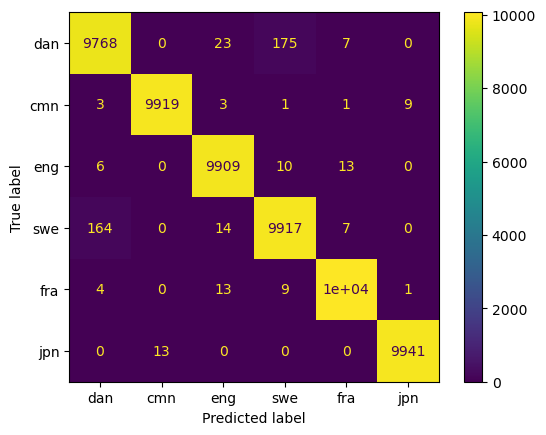

In [410]:
disp = ConfusionMatrixDisplay(confusion_matrix(
    y_val, y_val_pred), display_labels=display_labels)
disp.plot()

You may try to increase the number of iterations to improve the score. You may also try change the parameters of the multilayer percetron.

In [411]:
confusion_matrix(y_val, y_val_pred)

array([[ 9768,     0,    23,   175,     7,     0],
       [    3,  9919,     3,     1,     1,     9],
       [    6,     0,  9909,    10,    13,     0],
       [  164,     0,    14,  9917,     7,     0],
       [    4,     0,    13,     9, 10070,     1],
       [    0,    13,     0,     0,     0,  9941]])

## Predict the language of a text

Now you will predict the languages of the strings below.

In [412]:
docs = ["Salut les gars !", "Hejsan grabbar!", "Hello guys!", "Hejsan tjejer!"]

In [413]:
build_freq_dict('Salut les gars !')

{331: 0.1875,
 234: 0.125,
 15: 0.125,
 69: 0.0625,
 432: 0.0625,
 86: 0.1875,
 32: 0.0625,
 31: 0.0625,
 437: 0.0625,
 333: 0.0625,
 1078: 0.06666666666666667,
 640: 0.06666666666666667,
 582: 0.06666666666666667,
 1542: 0.06666666666666667,
 1492: 0.06666666666666667,
 900: 0.06666666666666667,
 739: 0.06666666666666667,
 1319: 0.06666666666666667,
 1238: 0.13333333333333333,
 982: 0.06666666666666667,
 1415: 0.06666666666666667,
 557: 0.06666666666666667,
 1161: 0.06666666666666667,
 1020: 0.06666666666666667,
 1803: 0.07142857142857142,
 1608: 0.07142857142857142,
 2199: 0.07142857142857142,
 2349: 0.07142857142857142,
 2284: 0.07142857142857142,
 1958: 0.07142857142857142,
 1720: 0.07142857142857142,
 1925: 0.07142857142857142,
 2370: 0.07142857142857142,
 2546: 0.07142857142857142,
 1752: 0.07142857142857142,
 1805: 0.07142857142857142,
 1670: 0.07142857142857142,
 2269: 0.07142857142857142}

Create features vectors from this list. Call this matrix `X_test`

In [414]:
# Write your code here
X_test = [build_freq_dict(i) for i in docs]
X_test = vectorizer.transform(X_test)

In [415]:
X_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

And run the prediction that you will store in a variable called `pred_languages`

In [416]:
# Write your code here
pred_languages = clf.predict(X_test)

In [417]:
list(map(lambda x: idx2lang[x], pred_languages))

['fra', 'swe', 'eng', 'dan']

## Building the Model with PyTorch
You will now recreate a PyTorch model with the same architecture as in sklearn.

### The Model
Create a model identical to the one you created with sklearn. Use the same activation function for the hidden layer and no activation in the last layer. Use the `Sequential` class.

In [418]:
input_dim = X.shape[1]
nbr_classes = len(langs)

In [419]:
# Write your code here
model = nn.Sequential(
          nn.Linear(input_dim, 50),
          nn.ReLU(),
          nn.Linear(50, nbr_classes),
        )

In [420]:
model

Sequential(
  (0): Linear(in_features=2583, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=6, bias=True)
)

Write the loss `loss_fn` and optimizer `optimizer`. As optimizer, use the same as in sklearn. See here: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

In [421]:
# Write your code here. (The solution is given)
loss_fn = nn.CrossEntropyLoss()    # cross entropy loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### The data loader

We convert the data to tensors

In [422]:
X_train = torch.Tensor(X_train)
y_train = torch.LongTensor(y_train)

X_val = torch.Tensor(X_val)
y_val = torch.LongTensor(y_val)

X_test = torch.Tensor(X_test)

In [423]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(X_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=32)

In [424]:
model.train()

Sequential(
  (0): Linear(in_features=2583, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=6, bias=True)
)

Fit your network on your training set. Write a code similar to that seen during the lecture and use five to seven epochs to start with. You will store the training and validation losses in a list so that you can plot them

In [425]:
ce_train_loss = []
ce_val_loss = []

for epoch in tqdm(range(7)):
    model.train()                       # sets PyTorch in the train mode
    train_loss = 0.0
    for X_batch, y_batch in train_dataloader:
        optimizer.zero_grad()           # resets the gradients
        outputs = model(X_batch)  
        loss = loss_fn(outputs, y_batch)
        loss.backward()                 # gradient backpropagation
        optimizer.step()                # weight updates
        train_loss += loss.item()       # accumulate loss

    ce_train_loss.append(train_loss / len(train_dataloader)) 

    model.eval()                        # set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():               # no gradient calculation during validation
        for X_batch, y_batch in val_dataloader:
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)
            val_loss += loss.item()     # accumulate validation loss

    ce_val_loss.append(val_loss / len(val_dataloader))

100%|██████████| 7/7 [02:24<00:00, 20.68s/it]


In [427]:
ce_train_loss, ce_val_loss

([0.101702569746001,
  0.023059292249349043,
  0.01849845592030591,
  0.015787538987275668,
  0.013688208010853548,
  0.011864638766249573,
  0.010298075954881393],
 [0.027446476521808653,
  0.024762831692019243,
  0.02338721023312537,
  0.02440978692722444,
  0.023959373786313062,
  0.02353935394606051,
  0.02357969449728327])

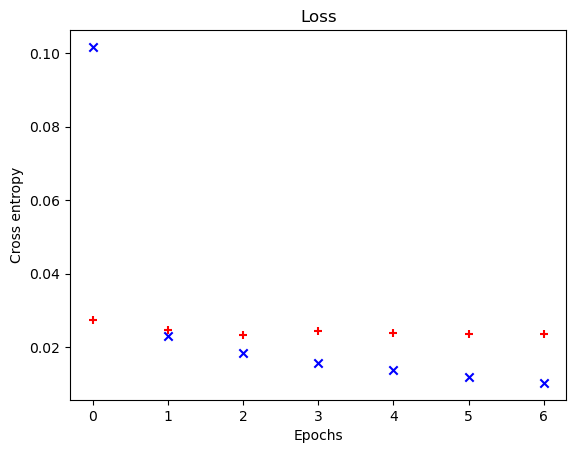

In [428]:
import matplotlib.pyplot as plt

plt.scatter(range(len(ce_train_loss)),
            ce_train_loss, c='b', marker='x')
plt.scatter(range(len(ce_train_loss)),
            ce_val_loss, c='r', marker='+')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Cross entropy')
plt.show()

Predict the validation set `X_val` in the form of logits. Call the result: `Y_val_pred_logits`

In [429]:
model.eval()

Sequential(
  (0): Linear(in_features=2583, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=6, bias=True)
)

In [443]:
# Write your code here
Y_val_pred_logits = model(X_val)

In [444]:
Y_val_pred_logits[:5]

tensor([[-10.8416,  23.1502, -18.0431, -13.2693, -21.9009,  -3.4377],
        [-13.2315,  25.7579, -12.4261, -15.1255, -27.2976,  -4.1794],
        [ -3.4883, -10.0736,  -0.5633,  -4.5726,   8.0989, -11.2956],
        [-11.6158,  -4.1683, -21.4113,  -8.5884, -17.8371,  21.8821],
        [-10.4179,  24.6599, -19.6919, -15.6911, -24.2082,  -1.9214]],
       grad_fn=<SliceBackward0>)

Predict the validation set `X_val` in the form of probabilities. Use `torch.softmax()` for that and call the result: `Y_val_pred_proba`

In [445]:
# Write your code here
Y_val_pred_proba = torch.softmax(Y_val_pred_logits, dim=1)

In [447]:
Y_val_pred_proba[:4]

tensor([[1.7279e-15, 1.0000e+00, 1.2881e-18, 1.5247e-16, 2.7199e-20, 2.8380e-12],
        [1.1672e-17, 1.0000e+00, 2.6117e-17, 1.7562e-18, 9.0843e-24, 9.9632e-14],
        [9.2822e-06, 1.2814e-08, 1.7296e-04, 3.1386e-06, 9.9981e-01, 3.7754e-09],
        [2.8318e-15, 4.8581e-12, 1.5774e-19, 5.8456e-14, 5.6261e-18, 1.0000e+00]],
       grad_fn=<SliceBackward0>)

Extract the categories from the probabilities in `Y_val_pred_proba`. Use the `torch.argmax()` function. Call the result `y_val_pred`. Check that the prediction corresponds to the real values.

In [448]:
# Write your code here
y_val_pred = torch.argmax(Y_val_pred_proba, dim=1)

In [449]:
y_val_pred[:20]

tensor([1, 1, 4, 5, 1, 0, 3, 3, 0, 5, 5, 2, 3, 0, 1, 5, 5, 3, 4, 4])

In [450]:
y_val[:20]

tensor([1, 1, 4, 5, 1, 0, 3, 3, 0, 5, 5, 2, 3, 0, 1, 5, 5, 3, 4, 4])

Print the evaluation

In [451]:
print(classification_report(y_val, y_val_pred, target_names=y_symbols))
print('Micro F1:', f1_score(y_val, y_val_pred, average='micro'))
print('Macro F1', f1_score(y_val, y_val_pred, average='macro'))

              precision    recall  f1-score   support

         dan       0.98      0.98      0.98      9973
         cmn       1.00      1.00      1.00      9936
         eng       1.00      1.00      1.00      9938
         swe       0.98      0.98      0.98     10102
         fra       1.00      1.00      1.00     10097
         jpn       1.00      1.00      1.00      9954

    accuracy                           0.99     60000
   macro avg       0.99      0.99      0.99     60000
weighted avg       0.99      0.99      0.99     60000

Micro F1: 0.9928
Macro F1 0.9928175212271312


Print the confusion matrix

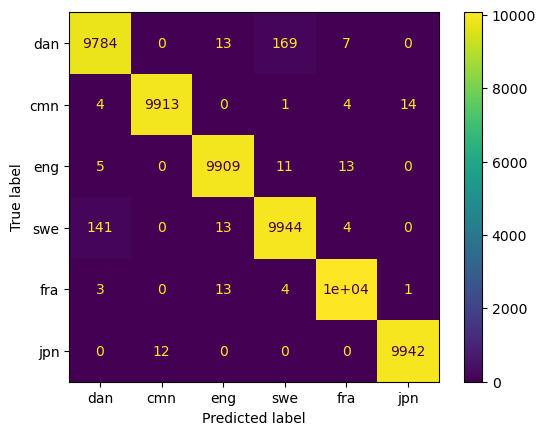

In [438]:
disp = ConfusionMatrixDisplay(confusion_matrix(
    y_val, y_val_pred), display_labels=display_labels)
disp.plot()

Predict your languages with PyTorch. Reuse `X_test` and call the result `Y_test_pred_proba`.

In [452]:
# Write your code here
Y_test_pred_proba = torch.softmax(model(X_test), dim=1)

In [453]:
Y_test_pred_proba

tensor([[6.8583e-08, 5.4781e-10, 1.1864e-07, 3.4697e-07, 1.0000e+00, 1.3437e-10],
        [1.2278e-05, 1.1664e-05, 1.5477e-06, 9.9997e-01, 1.4192e-07, 5.7873e-09],
        [3.5514e-01, 8.4425e-04, 6.2848e-01, 5.8930e-04, 1.4939e-02, 3.6062e-06],
        [9.8835e-01, 3.3455e-06, 2.5894e-08, 1.1642e-02, 3.2145e-08, 6.2598e-08]],
       grad_fn=<SoftmaxBackward0>)

From the probabilities, extract the predicted languages and map them to strings. Call the results `pred_languages_pytorch`.

In [454]:
# Write your code here
pred_languages_pytorch = list(map(lambda x: idx2lang[x], torch.argmax(Y_test_pred_proba, dim=1).tolist()))

In [442]:
pred_languages_pytorch

['fra', 'swe', 'eng', 'dan']

## Turning in your assignment

Now your are done with the program. To complete this assignment, you will write a report where you will:
1. Write a short individual report on your program. I recommend that you use this structure for your report:
      1. Objectives and dataset
      2. Method and program structure, where you should outline your program and possibly describe difficult parts.
      3. Results.
      4. Conclusion. As ideas for possible improvements, you may have a look at this paper: https://arxiv.org/pdf/2205.03983
2. In Sect. _Method and program structure_, do not forget to:
   * Summarize CLD3 and outline its architecture
   * Identify the features used by CLD3
   * Describe your architecture and tell how it is different from CLD3
   * Outline the differences between a sklearn and PyTorch program

The whole report should be of 2 to 3 pages.

Submit your report as well as your **notebook** (for archiving purposes) to Canvas: https://canvas.education.lu.se/. To write your report, please use Latex. This will probably help you structure your text. You will then upload a PDF file in Canvas. To write your document, you can use Overleaf (www.overleaf.com), an on-line Latex editor.

Please do not use MS Word or the likes. Do no write directly your text in Canvas, either, as will will not pass your report.

The submission deadline is October 11, 2024.

## Postscript from Pierre Nugues

I created this assignment from an examination I wrote in 2019 for the course on applied machine learning. I simplified it from the `README.md` on GitHub, https://github.com/google/cld3. I found the C++ code difficult to understand and I reimplemented a Keras/Tensorflow version of it from this `README`. Should you be interested, you can find it here: https://github.com/pnugues/language-detector.